<h1>Read Data</h1>

In [5]:
import os

path = "faces-png"
subfolders = os.listdir(path)
print("Sub Folder:", subfolders)

Sub Folder: ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']


In [6]:
png_files = []

for subfolder in subfolders:
    subfolder_path = os.path.join(path, subfolder)
    if os.path.isdir(subfolder_path):
        files_in_subfolder = [i for i in os.listdir(subfolder_path) if i.lower().endswith('.png')]
        png_files.extend([os.path.join(subfolder_path, i) for i in files_in_subfolder])

print("Isi:", png_files[:10])
print(len(png_files))

Isi: ['faces-png\\an2i\\an2i_left_angry_open.png', 'faces-png\\an2i\\an2i_left_angry_open_2.png', 'faces-png\\an2i\\an2i_left_angry_open_4.png', 'faces-png\\an2i\\an2i_left_angry_sunglasses.png', 'faces-png\\an2i\\an2i_left_angry_sunglasses_2.png', 'faces-png\\an2i\\an2i_left_angry_sunglasses_4.png', 'faces-png\\an2i\\an2i_left_happy_open.png', 'faces-png\\an2i\\an2i_left_happy_open_2.png', 'faces-png\\an2i\\an2i_left_happy_open_4.png', 'faces-png\\an2i\\an2i_left_happy_sunglasses.png']
1872


<h1>Data Explorations & Preprocessing</h1>

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
print("Ukuran gambar asli:")
for i, path in enumerate(png_files[:10]):
    img = Image.open(path)
    print(f"Gambar {i+1}: {img.size}")

Ukuran gambar asli:
Gambar 1: (128, 120)
Gambar 2: (64, 60)
Gambar 3: (32, 30)
Gambar 4: (128, 120)
Gambar 5: (64, 60)
Gambar 6: (32, 30)
Gambar 7: (128, 120)
Gambar 8: (64, 60)
Gambar 9: (32, 30)
Gambar 10: (128, 120)


In [9]:
def image_resize(file_path, size=(128, 128)):
    img = Image.open(file_path)
    img = img.convert('L')
    img_resized = img.resize(size, Image.Resampling.LANCZOS)
    return np.array(img), np.array(img_resized)

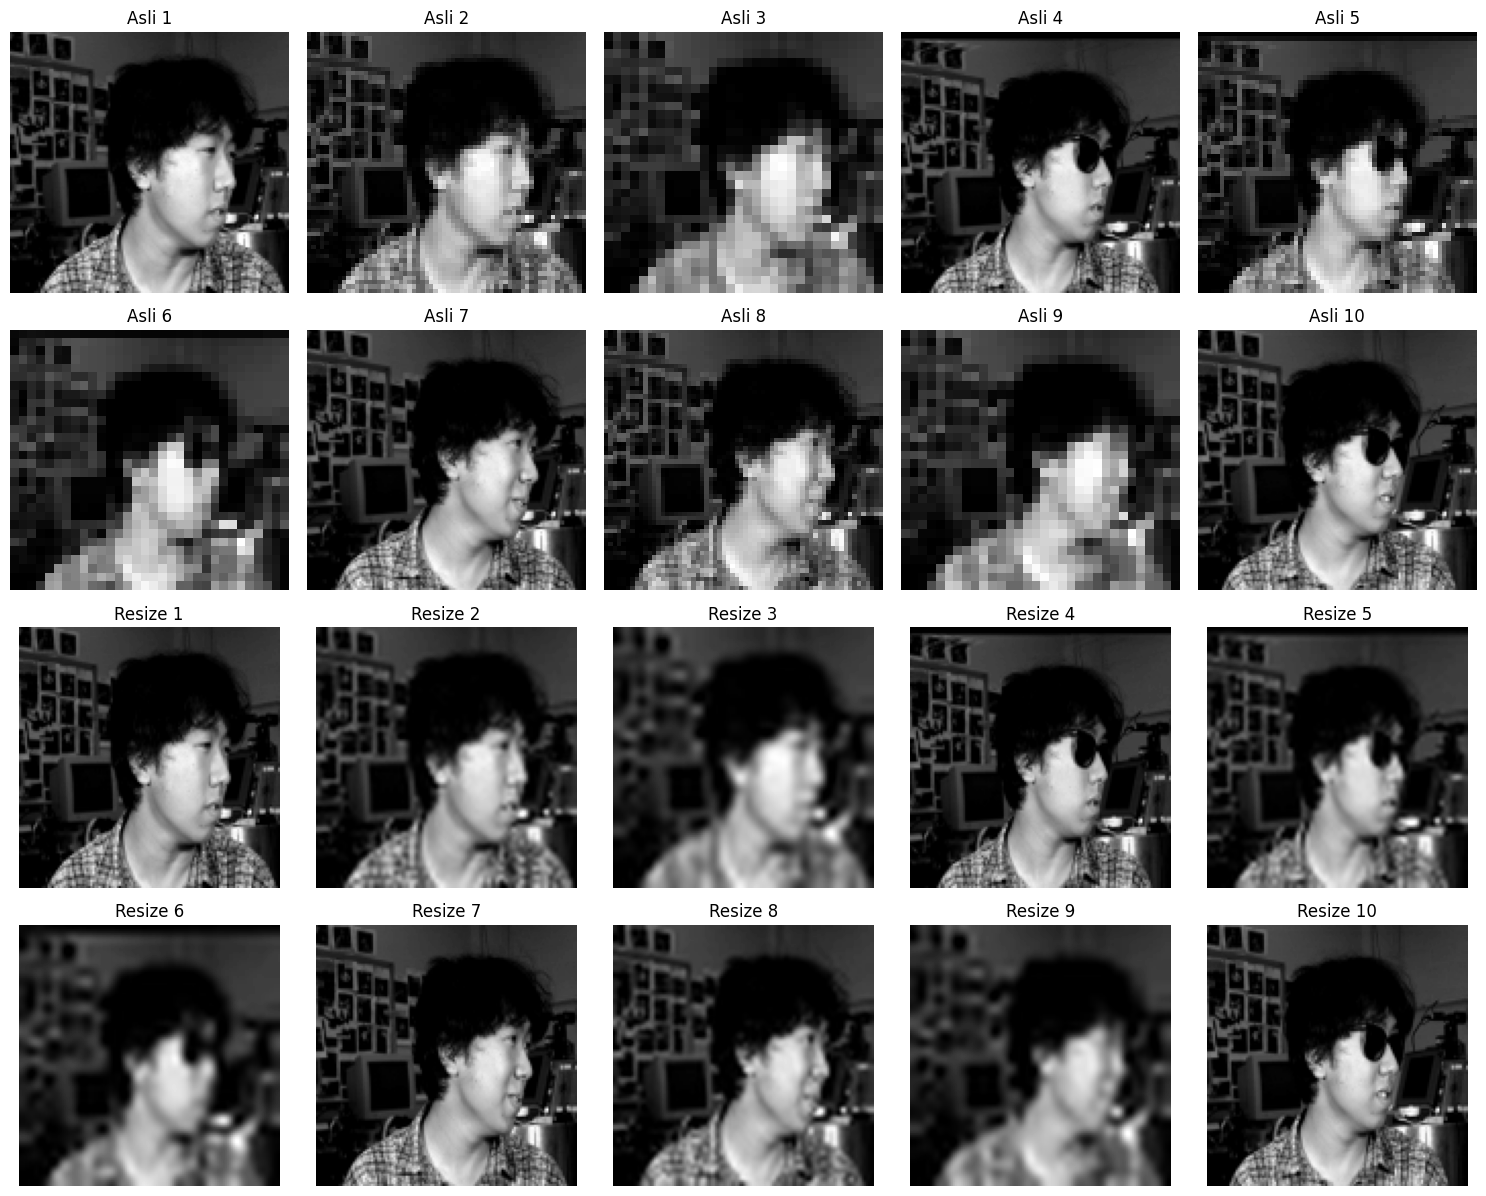

In [10]:
png_files.sort()
fig, axes = plt.subplots(4, 5, figsize=(15, 12))  
axes = axes.flatten()  
#sebelum resize
for i, image_path in enumerate(png_files[:10]):  # 10 gambar pertama
    original_image, resized_image = image_resize(image_path)
    # gambar asli 
    axes[i].imshow(original_image, cmap='gray') 
    axes[i].axis('off')  # Menghilangkan axis
    axes[i].set_title(f'Asli {i+1}')  
# hasil resize
for i, image_path in enumerate(png_files[:10]): 
    original_image, resized_image = image_resize(image_path)
    # gambar resize
    axes[i + 10].imshow(resized_image, cmap='gray')  
    axes[i + 10].axis('off')  
    axes[i + 10].set_title(f'Resize {i+1}')  
plt.tight_layout()
plt.show()

<h1>Label Encoder</h1>

In [11]:
from sklearn.preprocessing import LabelEncoder

poses = [i.split('_')[1] for i in png_files]  

pose_encoder = LabelEncoder()
pose_labels = pose_encoder.fit_transform(poses)

print("10 data pertama label encoded:", pose_labels[:10])  

print("Kelas label:", pose_encoder.classes_) 

10 data pertama label encoded: [0 0 0 0 0 0 0 0 0 0]
Kelas label: ['left' 'right' 'straight' 'up']


In [12]:
from collections import Counter
pose_counts = Counter(poses)

print("Distribusi kelas:")
for pose, count in pose_counts.items():
    print(f"{pose}: {count}")

Distribusi kelas:
left: 471
right: 465
straight: 468
up: 468


<h1>Pembagian Data</h1>

In [13]:
images_resized = [image_resize(f)[1] for f in png_files]  
X = np.array(images_resized) / 255.0  # Normalisasi gambar 0-1
y = pose_labels
print(X.shape)
print(y.shape)

(1872, 128, 128)
(1872,)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1497, 128, 128)
(1497,)
(375, 128, 128)
(375,)


In [16]:
X_train = X_train.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)
print(X_train.shape)
print(X_test.shape)

(1497, 128, 128, 1)
(375, 128, 128, 1)


<h1>Augmented</h1>

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest"
)
datagen.fit(X_train)
augmented_images = []
augmented_labels = []
for i in range(len(X_train)):
    x = X_train[i].reshape((1,) + X_train[i].shape)
    label = y_train[i]
    j = 0
    for batch in datagen.flow(x, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        j += 1
        if j >= 2:
            break 
print("Jumlah X sebelum augmentasi:", X_train.shape[0])
print("Jumlah y sebelum augmentasi:", X_train.shape[0])
X_augmented = np.array(augmented_images)
y_augmented = np.array(augmented_labels)
X_train = np.concatenate((X_train, X_augmented), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)
print("Jumlah X setelah augmentasi:", X_train.shape[0])
print("Jumlah y setelah augmentasi:", X_train.shape[0])

Jumlah X sebelum augmentasi: 1497
Jumlah y sebelum augmentasi: 1497
Jumlah X setelah augmentasi: 4491
Jumlah y setelah augmentasi: 4491


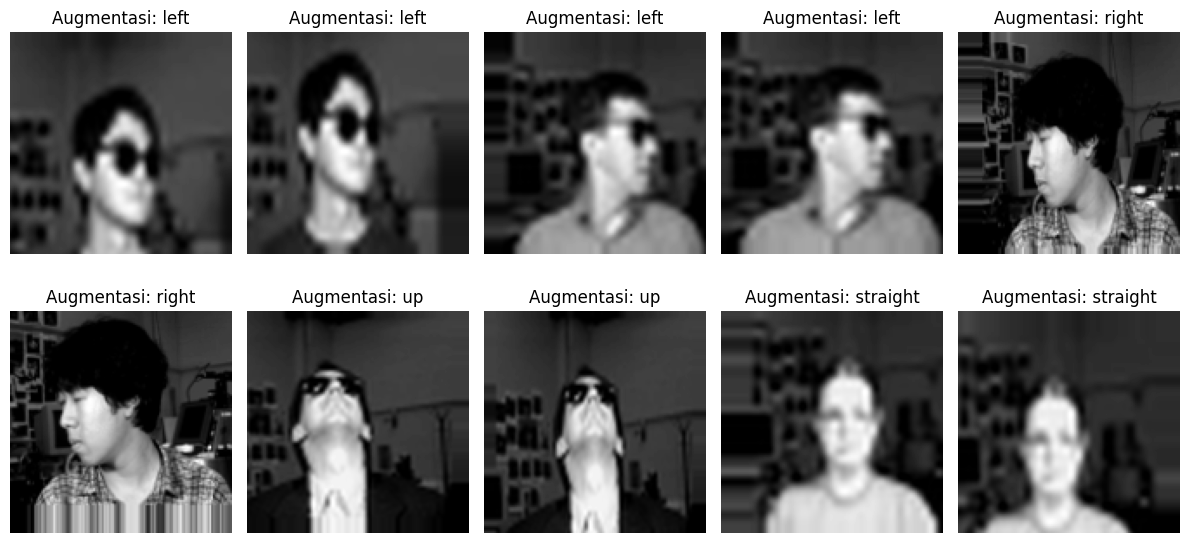

In [18]:
import random
plt.figure(figsize=(12, 6))
count = 0
i = 0
while count < 10 and i < len(X_augmented):
    img = X_augmented[i].squeeze()
    label = y_augmented[i]
    
    if not np.all(img == 0) and not np.isnan(img).any():
        img = np.clip(img, 0, 1)  
        plt.subplot(2, 5, count + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Augmentasi: {pose_encoder.inverse_transform([label])[0]}')
        plt.axis('off')
        count += 1
    i += 1
plt.tight_layout()
plt.show()

In [19]:
print(f"Total data asli: {X.shape[0]}")
print(f"Train: {X_train.shape[0]} (+ augmented: {X_augmented.shape[0]})")
print(f"Test: {X_test.shape[0]}")
print(f"X_train final: {X_train.shape}")
print(f"X_test final: {X_test.shape}")

Total data asli: 1872
Train: 4491 (+ augmented: 2994)
Test: 375
X_train final: (4491, 128, 128, 1)
X_test final: (375, 128, 128, 1)


In [20]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(f"X_train final: {X_train.shape}")
print(f"X_test final: {X_test.shape}")

X_train final: (4491, 16384)
X_test final: (375, 16384)


In [21]:
y_train_labels = pose_encoder.inverse_transform(y_train) 
pose_counts = Counter(y_train_labels)
print("Distribusi kelas y_train setelah augmentasi:")
for pose, count in pose_counts.items():
    print(f"{pose}: {count}")

Distribusi kelas y_train setelah augmentasi:
left: 1131
right: 1116
up: 1122
straight: 1122


<h1>PCA</h1>

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train shape setelah PCA: {X_train_pca.shape}")
print(f"X_test shape setelah PCA: {X_test_pca.shape}")

X_train shape setelah PCA: (4491, 304)
X_test shape setelah PCA: (375, 304)


<h1>Buat Model</h1>

In [23]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time

<h2>Random Forest</h2>

In [24]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
start_time_rf = time.time()
scores_rf = cross_val_score(rf_model, X_train_pca, y_train, cv=5, scoring='accuracy')
training_time_rf = time.time() - start_time_rf
print(f"Lama training + cross-val RF: {training_time_rf:.2f} detik")
for i, score in enumerate(scores_rf):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_rf.mean():.4f} ± {scores_rf.std():.4f}")

Lama training + cross-val RF: 24.60 detik
Akurasi Fold 1: 0.9822
Akurasi Fold 2: 0.9298
Akurasi Fold 3: 0.7940
Akurasi Fold 4: 0.7639
Akurasi Fold 5: 0.7728
Rata-rata akurasi (5-fold CV): 0.8486 ± 0.0898


<h2>SVM</h2>

In [25]:
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
start_time_svm = time.time()
scores_svm = cross_val_score(svm_model, X_train_pca, y_train, cv=5, scoring='accuracy', n_jobs=-1)
training_time_svm = time.time() - start_time_svm
print(f"Lama training + cross-val SVM: {training_time_svm:.2f} detik")
for i, score in enumerate(scores_svm):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_svm.mean():.4f} ± {scores_svm.std():.4f}")

Lama training + cross-val SVM: 21.77 detik
Akurasi Fold 1: 0.9299
Akurasi Fold 2: 0.8430
Akurasi Fold 3: 0.6292
Akurasi Fold 4: 0.5935
Akurasi Fold 5: 0.6180
Rata-rata akurasi (5-fold CV): 0.7227 ± 0.1370


<h2>KNN</h2>

In [26]:
knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
start_time_knn = time.time()
scores_knn = cross_val_score(knn_model, X_train_pca, y_train, cv=5, scoring='accuracy', n_jobs=-1)
training_time_knn = time.time() - start_time_knn
print(f"Lama training + cross-val KNN: {training_time_knn:.2f} detik")
for i, score in enumerate(scores_knn):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_knn.mean():.4f} ± {scores_knn.std():.4f}")

Lama training + cross-val KNN: 1.64 detik
Akurasi Fold 1: 0.8754
Akurasi Fold 2: 0.8263
Akurasi Fold 3: 0.5735
Akurasi Fold 4: 0.5646
Akurasi Fold 5: 0.5947
Rata-rata akurasi (5-fold CV): 0.6869 ± 0.1351


<h2>Votting</h2>

In [27]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42)))  # Menambahkan SVM
]

voting_model = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

start_time_voting = time.time()
scores_voting = cross_val_score(voting_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
training_time_voting = time.time() - start_time_voting

print(f"Lama training + cross-val Voting: {training_time_voting:.2f} detik")
for i, score in enumerate(scores_voting):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_voting.mean():.4f} ± {scores_voting.std():.4f}")


Lama training + cross-val Voting: 182.77 detik
Akurasi Fold 1: 0.9933
Akurasi Fold 2: 0.9588
Akurasi Fold 3: 0.8641
Akurasi Fold 4: 0.8508
Akurasi Fold 5: 0.8552
Rata-rata akurasi (5-fold CV): 0.9045 ± 0.0596


<h1>Hyperparameter Tunning</h1>

<h2>Random Forest</h2>

In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]   
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 2)

start_time_rf = time.time()
grid_search.fit(X_train_pca, y_train)
training_time_rf = time.time() - start_time_rf

best_params_rf = grid_search.best_params_

print(f"Lama training + Grid Search RF: {training_time_rf:.2f} detik")
print(f"Best parameters: {best_params_rf}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_
scores_rf = cross_val_score(best_rf_model, X_train_pca, y_train, cv=5, scoring='accuracy')
for i, score in enumerate(scores_rf):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_rf.mean():.4f} ± {scores_rf.std():.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Lama training + Grid Search RF: 284.11 detik
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.8682
Akurasi Fold 1: 0.9867
Akurasi Fold 2: 0.9365
Akurasi Fold 3: 0.8051
Akurasi Fold 4: 0.7962
Akurasi Fold 5: 0.8163
Rata-rata akurasi (5-fold CV): 0.8682 ± 0.0782


<h2>SVM</h2>

In [29]:
svm_model = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C': [0.1, 1, 10],  
    'svc__kernel': ['linear', 'rbf',],
    'svc__gamma': ['scale']
}

grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

start_time_svm = time.time()
grid_search_svm.fit(X_train_pca, y_train)
training_time_svm = time.time() - start_time_svm

best_params_svm = grid_search_svm.best_params_

print(f"Lama training + Grid Search SVM: {training_time_svm:.2f} detik")
print(f"Best parameters: {best_params_svm}")
print(f"Best cross-validation score: {grid_search_svm.best_score_:.4f}")

best_svm_model = grid_search_svm.best_estimator_
scores_svm = cross_val_score(best_svm_model, X_train_pca, y_train, cv=5, scoring='accuracy')
for i, score in enumerate(scores_svm):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_svm.mean():.4f} ± {scores_svm.std():.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Lama training + Grid Search SVM: 772.94 detik
Best parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best cross-validation score: 0.8486
Akurasi Fold 1: 0.9933
Akurasi Fold 2: 0.9287
Akurasi Fold 3: 0.7951
Akurasi Fold 4: 0.7494
Akurasi Fold 5: 0.7762
Rata-rata akurasi (5-fold CV): 0.8486 ± 0.0952


<h2>KNN</h2>

In [30]:
knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10],  
    'kneighborsclassifier__weights': ['uniform', 'distance'],  
    'kneighborsclassifier__metric': ['euclidean', 'manhattan'],
}

grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

start_time_knn = time.time()
grid_search_knn.fit(X_train_pca, y_train)
training_time_knn = time.time() - start_time_knn

best_params_knn = grid_search_knn.best_params_

print(f"Lama training + Grid Search KNN: {training_time_knn:.2f} detik")
print(f"Best parameters: {best_params_knn}")
print(f"Best cross-validation score: {grid_search_knn.best_score_:.4f}")

best_knn_model = grid_search_knn.best_estimator_
scores_knn = cross_val_score(best_knn_model, X_train_pca, y_train, cv=5, scoring='accuracy')
for i, score in enumerate(scores_knn):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_knn.mean():.4f} ± {scores_knn.std():.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Lama training + Grid Search KNN: 6.95 detik
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Best cross-validation score: 0.7530
Akurasi Fold 1: 0.9466
Akurasi Fold 2: 0.8731
Akurasi Fold 3: 0.6537
Akurasi Fold 4: 0.6481
Akurasi Fold 5: 0.6437
Rata-rata akurasi (5-fold CV): 0.7530 ± 0.1302


<h2>Voting</h2>

<h3>Voting Hard</h3>

In [53]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))) 
]
voting_model = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10],
    'knn__kneighborsclassifier__n_neighbors': [3, 5],
    'knn__kneighborsclassifier__weights': ['distance'],
    'et__n_estimators': [100, 200],
    'svm__svc__C': [1, 10],
    'svm__svc__kernel': ['rbf']
}
grid_search_voting = GridSearchCV(estimator=voting_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
start_time_voting = time.time()
grid_search_voting.fit(X_train_pca, y_train)
training_time_voting = time.time() - start_time_voting
best_params_voting = grid_search_voting.best_params_
print(f"Lama training + Grid Search Voting: {training_time_voting:.2f} detik")
print(f"Best parameters: {best_params_voting}")
print(f"Best cross-validation score: {grid_search_voting.best_score_:.4f}")
best_voting_model = grid_search_voting.best_estimator_
scores_voting = cross_val_score(best_voting_model, X_train_pca, y_train, cv=5, scoring='accuracy')
for i, score in enumerate(scores_voting):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_voting.mean():.4f} ± {scores_voting.std():.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Lama training + Grid Search Voting: 966.58 detik
Best parameters: {'et__n_estimators': 200, 'knn__kneighborsclassifier__n_neighbors': 3, 'knn__kneighborsclassifier__weights': 'distance', 'rf__max_depth': None, 'rf__n_estimators': 100, 'svm__svc__C': 10, 'svm__svc__kernel': 'rbf'}
Best cross-validation score: 0.8780
Akurasi Fold 1: 0.9922
Akurasi Fold 2: 0.9432
Akurasi Fold 3: 0.8118
Akurasi Fold 4: 0.8140
Akurasi Fold 5: 0.8285
Rata-rata akurasi (5-fold CV): 0.8780 ± 0.0751


<h3>Voting Soft</h3>

In [52]:
estimators_soft = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))) 
]
voting_model_soft = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1) 
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10],
    'knn__kneighborsclassifier__n_neighbors': [3, 5],
    'knn__kneighborsclassifier__weights': ['distance'],
    'et__n_estimators': [100, 200],
    'svm__svc__C': [1, 10],
    'svm__svc__kernel': ['rbf']
}
grid_search_voting_soft = GridSearchCV(
    estimator=voting_model_soft,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
start_time_voting_soft = time.time()
grid_search_voting_soft.fit(X_train_pca, y_train)
training_time_voting_soft = time.time() - start_time_voting_soft
best_params_voting_soft = grid_search_voting_soft.best_params_
print(f"Lama training + Grid Search Voting: {training_time_voting_soft:.2f} detik")
print(f"Best parameters: {best_params_voting_soft}")
print(f"Best cross-validation score: {grid_search_voting_soft.best_score_:.4f}")
best_voting_soft_model = grid_search_voting_soft.best_estimator_
scores_voting_soft = cross_val_score(best_voting_soft_model, X_train_pca, y_train, cv=5, scoring='accuracy')
for i, score in enumerate(scores_voting_soft):
    print(f"Akurasi Fold {i+1}: {score:.4f}")
print(f"Rata-rata akurasi (5-fold CV): {scores_voting_soft.mean():.4f} ± {scores_voting_soft.std():.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Lama training + Grid Search Voting: 1009.66 detik
Best parameters: {'et__n_estimators': 100, 'knn__kneighborsclassifier__n_neighbors': 5, 'knn__kneighborsclassifier__weights': 'distance', 'rf__max_depth': None, 'rf__n_estimators': 50, 'svm__svc__C': 10, 'svm__svc__kernel': 'rbf'}
Best cross-validation score: 0.8604
Akurasi Fold 1: 0.9933
Akurasi Fold 2: 0.9421
Akurasi Fold 3: 0.8051
Akurasi Fold 4: 0.7773
Akurasi Fold 5: 0.7840
Rata-rata akurasi (5-fold CV): 0.8604 ± 0.0896


<h1>Analisis</h1>

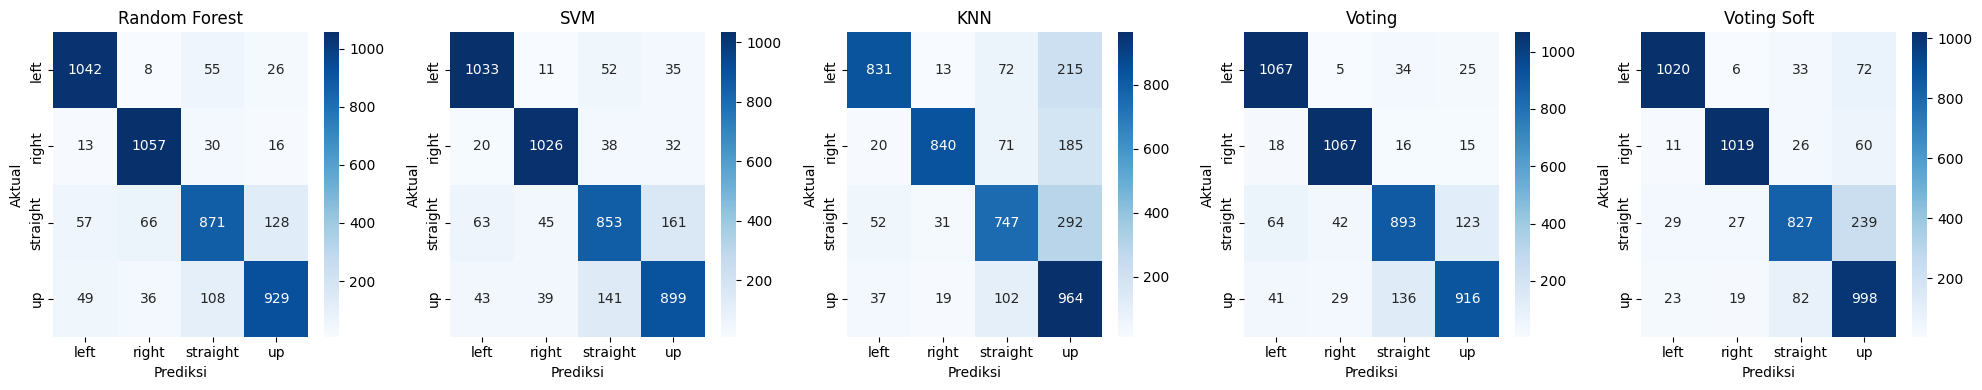

In [75]:
models = [
    ('Random Forest', best_rf_model),
    ('SVM', best_svm_model),
    ('KNN', best_knn_model),
    ('Voting', best_voting_model), 
    ('Voting Soft', best_voting_soft_model)
]
fig, axes = plt.subplots(1, len(models), figsize=(20, 4))  
for i, (name, model) in enumerate(models):
    y_pred = cross_val_predict(model, X_train_pca, y_train, cv=5, n_jobs=-1)
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=pose_encoder.classes_,
                yticklabels=pose_encoder.classes_,
                ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Prediksi")
    axes[i].set_ylabel("Aktual")
plt.tight_layout()
plt.show()

<p>Gambar diatas menunjukan hasil dari bebrapa model seperti Random Forest, SVM, KNN, Voting, dan Voting Soft, hasil diatas menunjukkan bahwa Voting Soft dan Voting Hard memberikan hasil yang paling seimbang dan akurat di seluruh kelas, dengan Random Forest dan SVM juga menunjukkan kinerja baik meskipun ada beberapa kesalahan pada kelas tertentu, sementara KNN memiliki hasil terbaik untuk arah straight, namun kurang baik di arah right dan up.</p>

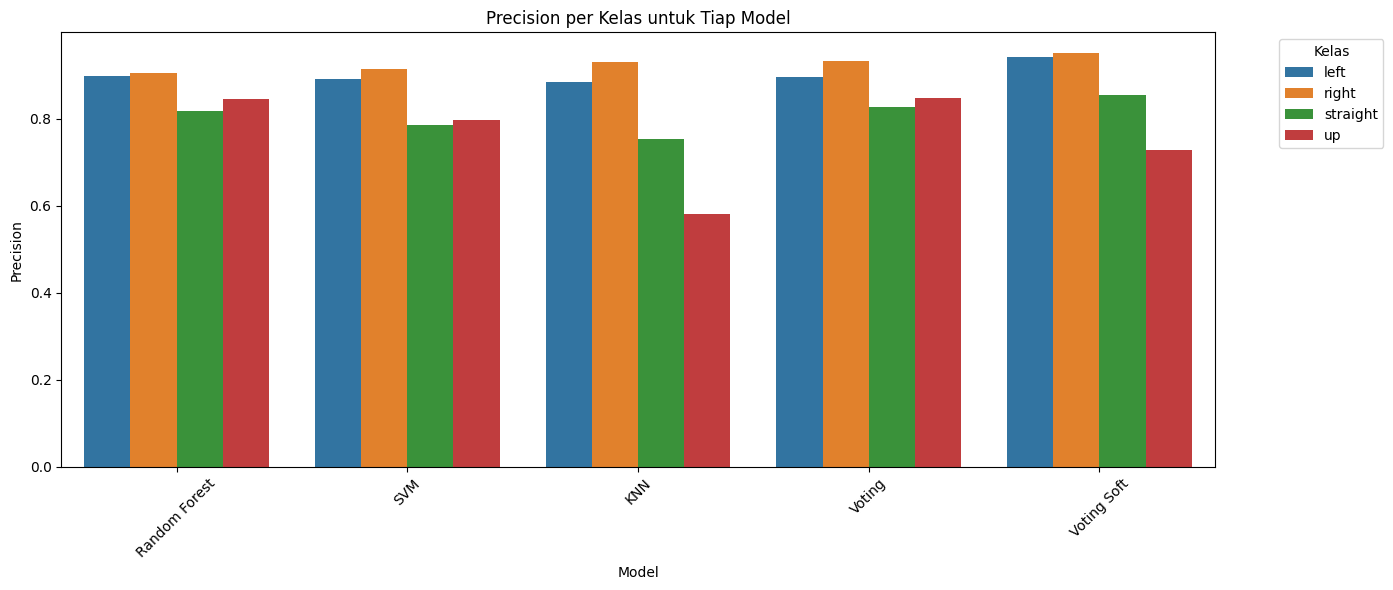

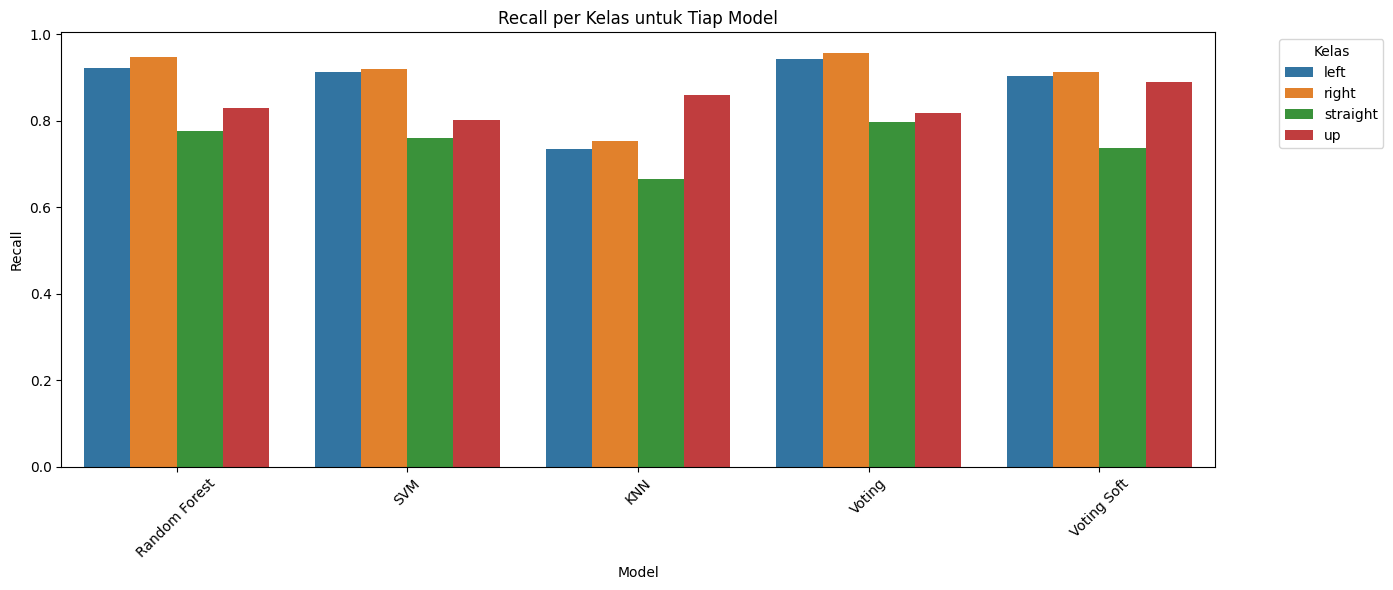

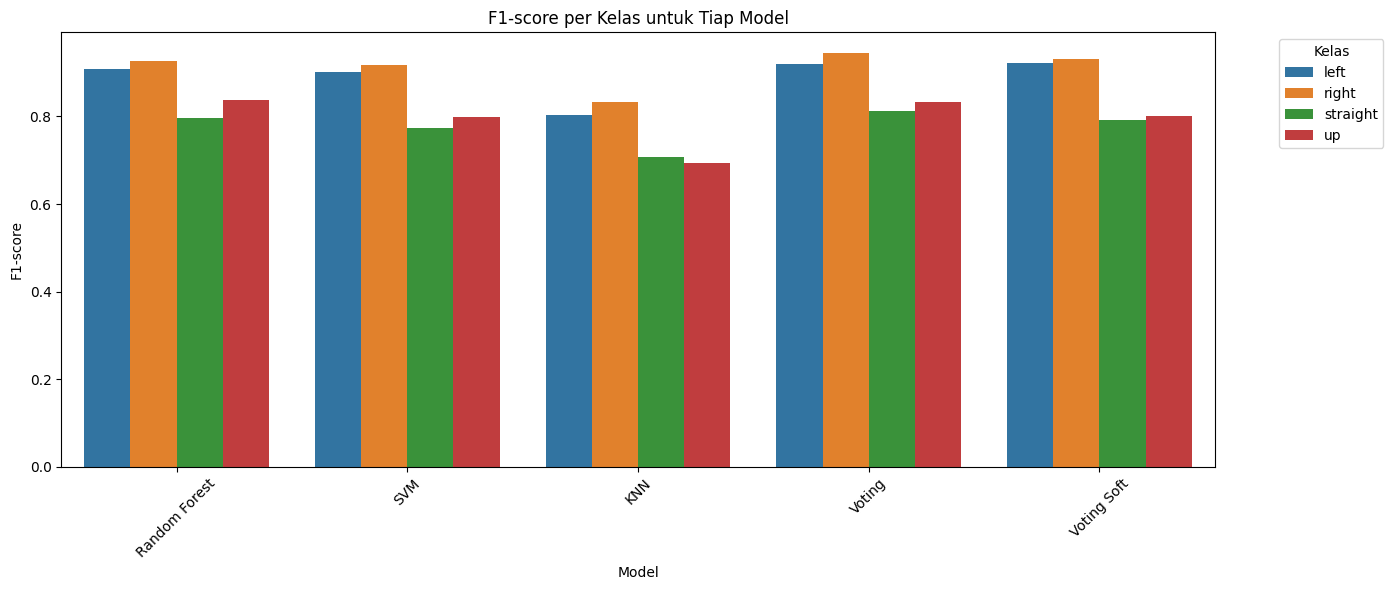

In [76]:
import pandas as pd
metrics_df = pd.DataFrame()
for name, model in models:
    y_pred = cross_val_predict(model, X_train_pca, y_train, cv=5, n_jobs=-1)
    report = classification_report(
        y_train, y_pred,
        target_names=pose_encoder.classes_,
        labels=range(len(pose_encoder.classes_)),
        output_dict=True
    )
    df = pd.DataFrame(report).transpose()
    df['model'] = name
    metrics_df = pd.concat([metrics_df, df])
filtered_df = metrics_df[
    metrics_df.index.isin(pose_encoder.classes_)
][['precision', 'recall', 'f1-score', 'model']]
filtered_df = filtered_df.reset_index().rename(columns={'index': 'kelas'})
for metric in ['precision', 'recall', 'f1-score']:
    plt.figure(figsize=(14, 6))
    sns.barplot(
        data=filtered_df,
        x='model',
        y=metric,
        hue='kelas'
    )
    plt.title(f"{metric.capitalize()} per Kelas untuk Tiap Model")
    plt.xticks(rotation=45)
    plt.ylabel(metric.capitalize())
    plt.xlabel("Model")
    plt.legend(title='Kelas', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

<p>Berdasarkan gambar diatas yang merupakan metrik Precision, Recall, dan F1-score, Voting Soft menunjukkan performa terbaik di hampir semua metrik, terutama pada kelas left dan right, diikuti oleh Voting Hard yang juga memberikan hasil yang sangat baik di sebagian besar kelas. Random Forest dan KNN menunjukkan kinerja yang cukup stabil, meskipun sedikit lebih rendah pada kelas right dan up. Sementara itu, SVM menunjukkan performa yang sedikit lebih lemah pada kelas right dan up. Secara keseluruhan, Voting Soft dan Voting lebih konsisten di berbagai metrik, sedangkan Random Forest dan KNN memberikan hasil yang stabil meskipun ada perbedaan kecil pada beberapa kelas.</p>

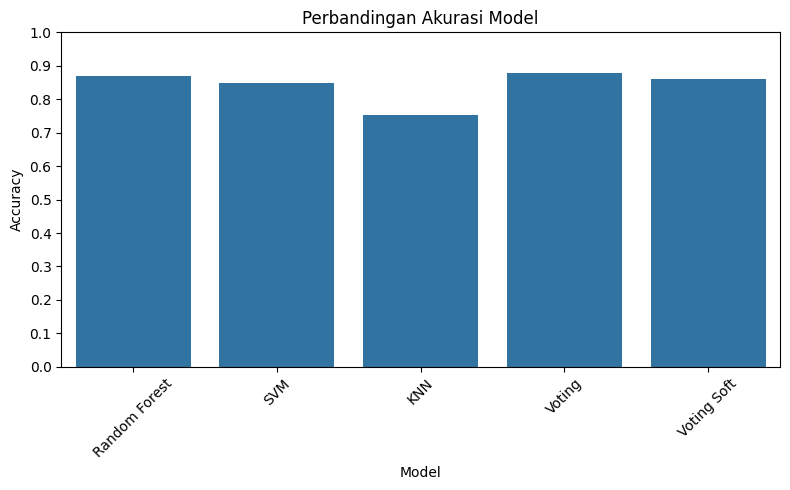

In [77]:
from sklearn.metrics import accuracy_score
accuracies = []
for name, model in models:
    y_pred = cross_val_predict(model, X_train_pca, y_train, cv=5, n_jobs=-1)
    acc = accuracy_score(y_train, y_pred)
    accuracies.append((name, acc))
df_acc = pd.DataFrame(accuracies, columns=["Model", "Accuracy"])
plt.figure(figsize=(8, 5))
sns.barplot(data=df_acc, x="Model", y="Accuracy")
plt.title("Perbandingan Akurasi Model")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()

<p>Berdasarkan grafik diatas, terlihat bahwa model Voting Classifier memiliki akurasi tertinggi dibandingkan model lainnya. Posisi kedua ditempati oleh Random Forest, diikuti oleh Voting Soft dan SVM yang memiliki akurasi yang cukup sebanding. Sementara, KNN menunjukkan performa terendah di antara semua model yang diuji. Perbedaan akurasi secara umum tidak terlalu besar, kecuali pada KNN yang cukup berbeda dibanding model lain.</p>

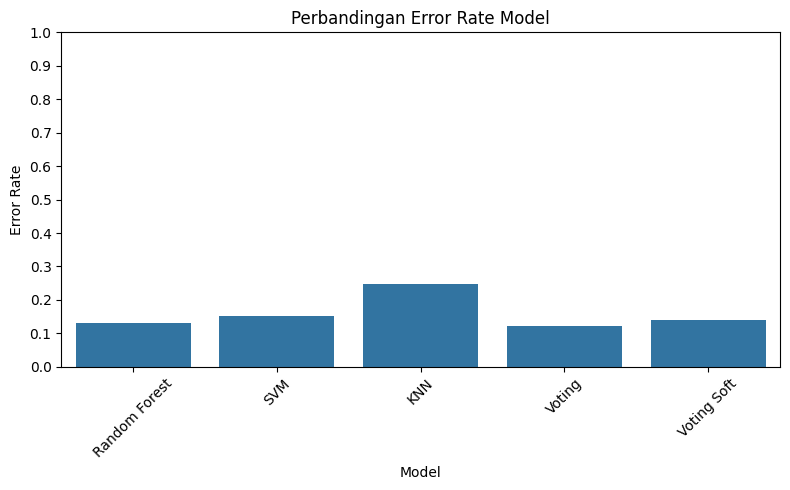

In [79]:
error_rates = []
for name, model in models:
    y_pred = cross_val_predict(model, X_train_pca, y_train, cv=5, n_jobs=-1)
    acc = accuracy_score(y_train, y_pred)
    error = 1 - acc
    error_rates.append((name, error))
df_error = pd.DataFrame(error_rates, columns=["Model", "Error Rate"])
plt.figure(figsize=(8, 5))
sns.barplot(data=df_error, x="Model", y="Error Rate")
plt.title("Perbandingan Error Rate Model")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<p>Berdasarkan grafik tersebut, terlihat bahwa KNN memiliki tingkat kesalahan (error rate) tertinggi dibandingkan dengan model-model lainnya. Sementara, Voting dan Random Forest menunjukkan error rate yang paling rendah, diikuti oleh Voting Soft dan SVM dengan nilai yang saling berdekatan. Ini berarti KNN Memberikan prediksi yang keliru dan tidak akurat</p>

<h1>Evaluasi Model</h1>

In [105]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
def evaluasi_model(model, X_test_pca, y_test):
    # Prediksi kelas
    y_pred = model.predict(X_test_pca)
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=list(pose_encoder.classes_))
    # label ROC-AUC
    classes = list(range(len(pose_encoder.classes_)))
    y_test_bin = label_binarize(y_test, classes=classes)
    # Prediksi probabilitas
    try:
        y_score = model.predict_proba(X_test_pca.reshape(X_test_pca.shape[0], -1))
    except Exception as e:
        print(e)
        y_score = None
    # ROC AUC
    if y_score is not None:
        try:
            auc_score = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')
        except Exception as e:
            print("ROC AUC calculation error:", e)
            auc_score = 'N/A'
        # Per kelas
        plt.figure(figsize=(10, 7))
        for i, class_label in enumerate(pose_encoder.classes_):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f'ROC curve of class {class_label} (area = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-class ROC Curve')
        plt.grid(True)
        plt.legend(loc='lower right')
        plt.show()
    else:
        auc_score = 'N/A'
    print(f"ROC AUC Score (weighted): {auc_score}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=pose_encoder.classes_,
                yticklabels=pose_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

<h2>Evaluasi Random Forest</h2>

Evaluasi Random Forest:


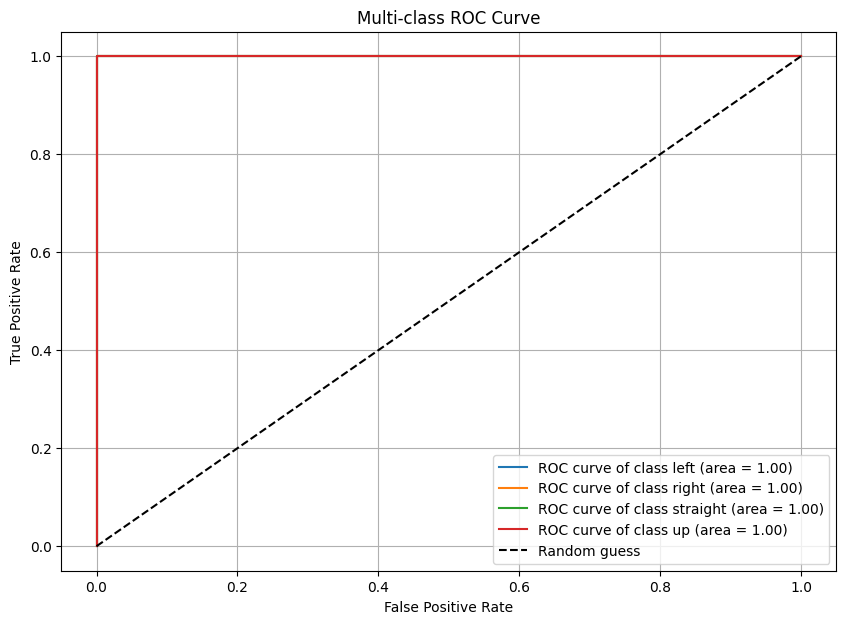

ROC AUC Score (weighted): 1.0
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

        left       1.00      1.00      1.00        94
       right       1.00      1.00      1.00        93
    straight       1.00      1.00      1.00        94
          up       1.00      1.00      1.00        94

    accuracy                           1.00       375
   macro avg       1.00      1.00      1.00       375
weighted avg       1.00      1.00      1.00       375



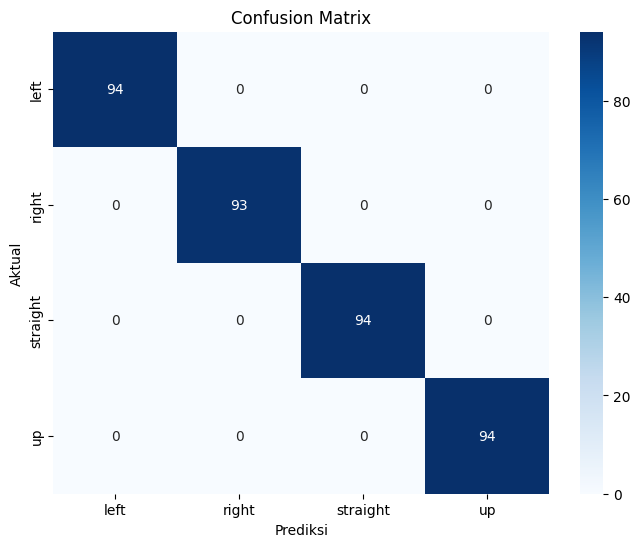

In [106]:
print("Evaluasi Random Forest:")
evaluasi_model(best_rf_model, X_test_pca, y_test)

<h2>Evaluasi SVM</h2>

Evaluasi SVM:


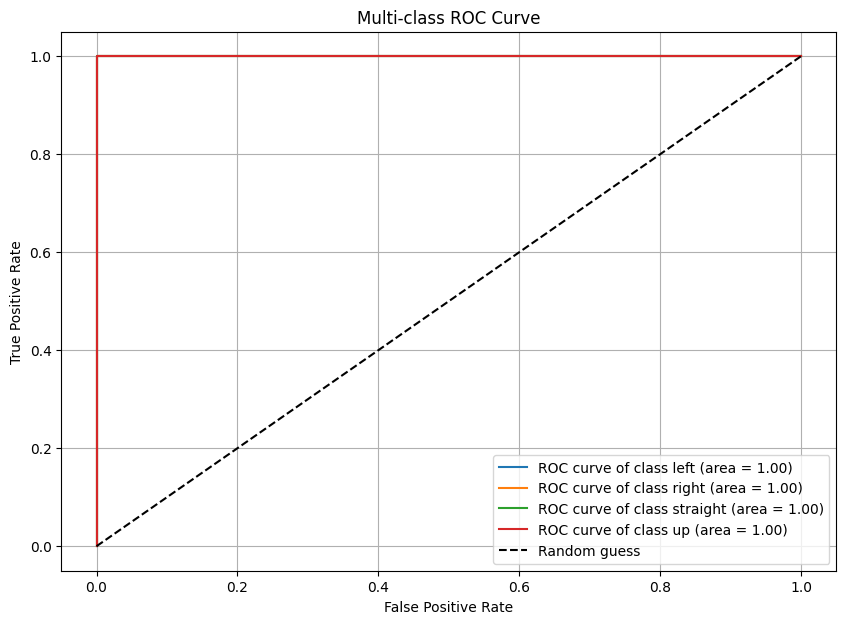

ROC AUC Score (weighted): 1.0
Accuracy: 0.9920
Classification Report:
               precision    recall  f1-score   support

        left       1.00      1.00      1.00        94
       right       1.00      0.97      0.98        93
    straight       1.00      1.00      1.00        94
          up       0.97      1.00      0.98        94

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



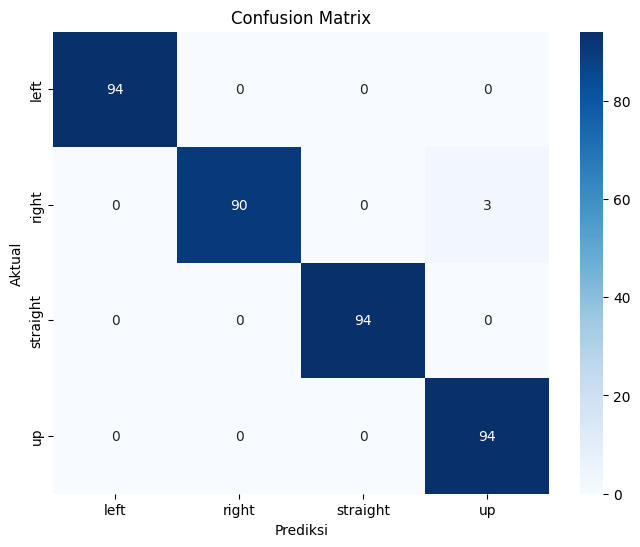

In [107]:
print("Evaluasi SVM:")
evaluasi_model(best_svm_model, X_test_pca, y_test)

<h2>Evaluasi KNN</h2>

Evaluasi KNN:


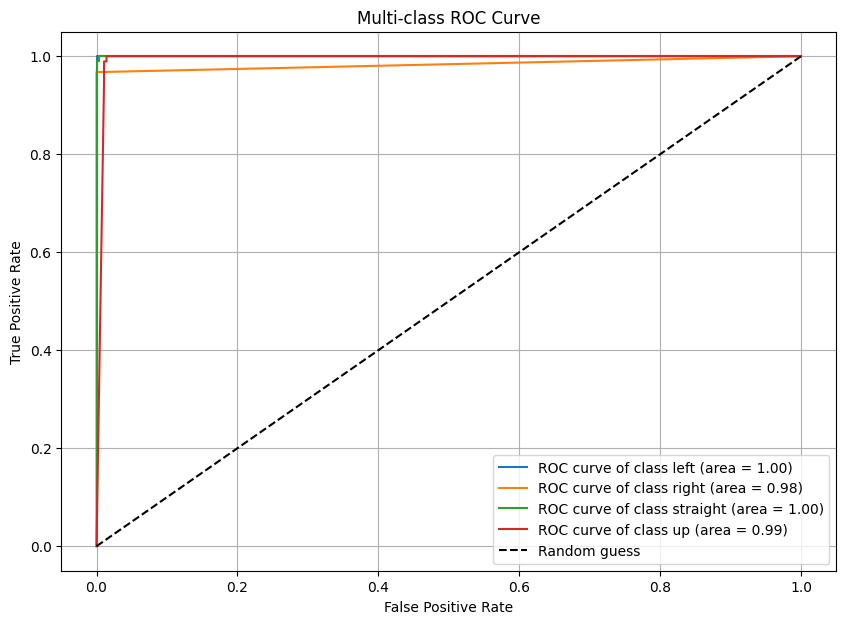

ROC AUC Score (weighted): 0.9945433987027081
Accuracy: 0.9893
Classification Report:
               precision    recall  f1-score   support

        left       1.00      1.00      1.00        94
       right       1.00      0.97      0.98        93
    straight       0.99      1.00      0.99        94
          up       0.97      0.99      0.98        94

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



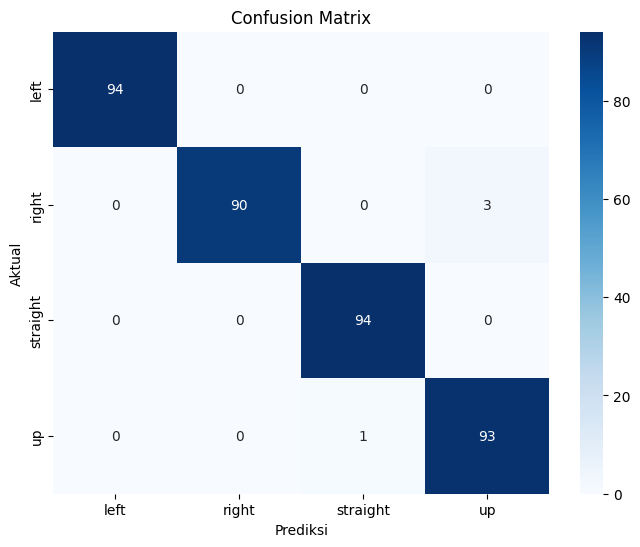

In [108]:
print("Evaluasi KNN:")
evaluasi_model(best_knn_model, X_test_pca, y_test)

<h2>Evaluasi Voting Hard</h2>

Evaluasi Voting Hard:
This 'VotingClassifier' has no attribute 'predict_proba'
ROC AUC Score (weighted): N/A
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

        left       1.00      1.00      1.00        94
       right       1.00      1.00      1.00        93
    straight       1.00      1.00      1.00        94
          up       1.00      1.00      1.00        94

    accuracy                           1.00       375
   macro avg       1.00      1.00      1.00       375
weighted avg       1.00      1.00      1.00       375



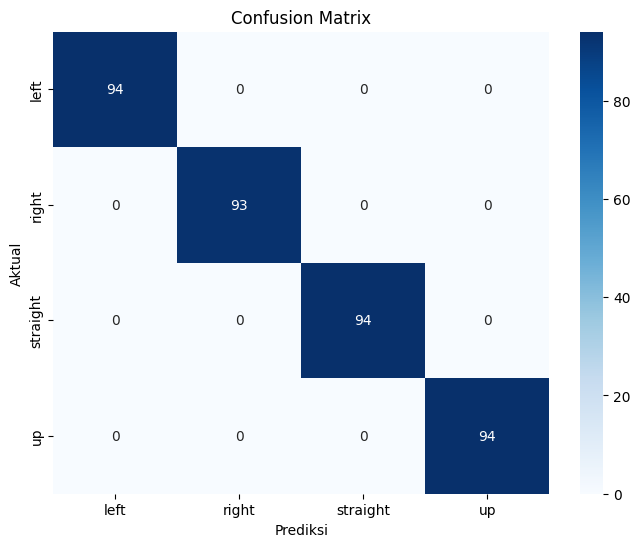

In [109]:
print("Evaluasi Voting Hard:")
evaluasi_model(best_voting_model, X_test_pca, y_test)

<h2>Evaluasi Voting Soft</h2>

Evaluasi Voting Soft:


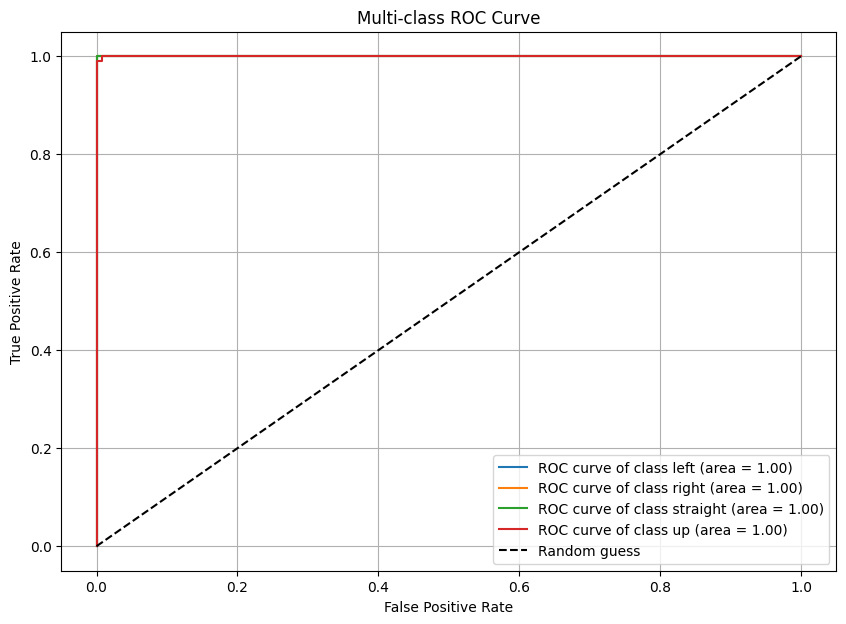

ROC AUC Score (weighted): 0.9999810201660736
Accuracy: 0.9920
Classification Report:
               precision    recall  f1-score   support

        left       1.00      1.00      1.00        94
       right       1.00      0.97      0.98        93
    straight       1.00      1.00      1.00        94
          up       0.97      1.00      0.98        94

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



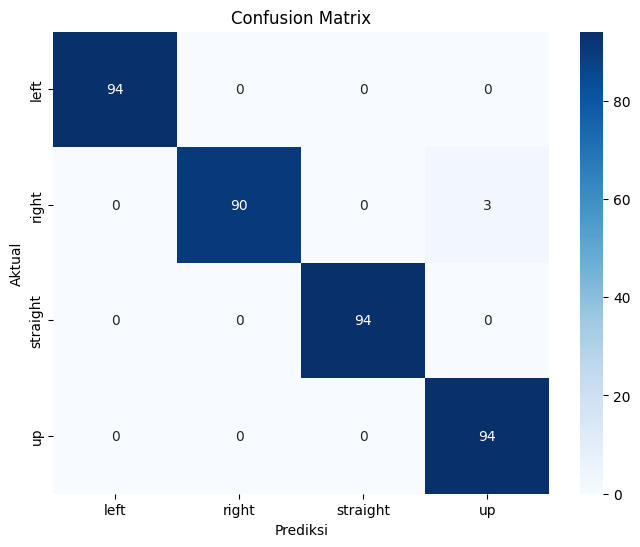

In [110]:
print("Evaluasi Voting Soft:")
evaluasi_model(best_voting_soft_model, X_test_pca, y_test)

<h1>Save Model</h1>

In [92]:
import pickle
with open('pose.pkl', 'wb') as f:
    pickle.dump(pose_encoder, f)

In [93]:
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

In [94]:
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

In [95]:
with open('best_svm_model.pkl', 'wb') as f:
    pickle.dump(best_svm_model, f)

In [96]:
with open('best_knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn_model, f)

In [97]:
with open('best_voting_model.pkl', 'wb') as f:
    pickle.dump(best_voting_model, f)

In [98]:
with open('best_voting_soft_model.pkl', 'wb') as f:
    pickle.dump(best_voting_soft_model, f)

<h1>Link Prediksi Pose</h1>

[<h3>Link Streamlit Prediksi Pose</h3>](https://prediksi-pose.streamlit.app/)

<h1>Terima Kasih</h1>